In [8]:
import numpy as np
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
from scipy.stats import norm


## Logit trick
We use logit transformation to map $[0,1] \to \mathbb{R}$. Introducing the auxiliary process:
$$
\tilde{Y} := w*\text{logit} (Y/w) = w*\ln\left(\frac{Y/w}{1-Y/w}\right)=f(Y)~,
$$ and clamping $dY_t$ by: 
$$dY_t=w(1-Y_t/w)(Y_t/w)Z_tdB,$$
we then apply $\textit{It}\hat{o}  \textit{'s formula}$ (with superscript $[\cdot]^i$ omiited):

$$
\begin{aligned} 
    d \tilde{Y}_t &= \partial_{Y}f*dY_t + \frac{1}{2} \partial^2_{Y}f*d[Y,Y](t)\\ 
                    &= \frac{1}{(Y_t/w)\left(1-Y_t/w\right)}*dY_t+\frac{1}{2}*\frac{2}{(Y_t/w)^2\left(1-Y_t/w\right)^2}*(\frac{w}{2}-Y_t)*d[Y,Y](t)\\
                    &= (w/2-Y_t)Z_t^2dt + wZ_tdB_t\\
\end{aligned}
$$

:bulb: Note here the NN models `y0_model_main` we're training is for $\tilde{Y}_0^i$, and `z_models_main` is a list of NN models for the parameterized stepwise drifts in $\tilde{Y}_t^i$.

In [9]:
#Model and Params
#Model and Params
NumTrain=500
NT=80
dt=1/NT
delta=0.05
K=0.9
w=1.0
mean=0.6
sd=0.1
learning_rate = 0.001

loss_type='BCEWithLogitsLoss'
target_type='indicator'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

#Forward Loss
forward_losses = []
#Network Class for FBSDE
class Network(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_outputs):
        '''
        lr: learning rate
        '''
        super(Network, self).__init__()

        #Pass input parameters
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_out = n_outputs

        #Construct network
        self.fc1 = nn.Linear(self.input_dims, self.fc1_dims)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_out)
        nn.init.xavier_uniform_(self.fc3.weight)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, input):
        x = F.relu(self.fc1(input))
        x= F.relu(self.fc2(x))
        output = self.fc3(x)
        return output
    
    
## Functions
def Sample_Init(N,mean=0,sd=0.1):
    '''
    Generate N samples of x0
    '''
    xi = np.random.normal(mean,sd,size=N)

    return torch.FloatTensor(xi).view(-1,1)

def SampleBMIncr(T, Npaths, Nsteps):
    # Returns Matrix of Dimension Npaths x Nsteps With Sample Increments of of BM
    # Here an increment is of the form dB
    dt = T / Nsteps
    dB = np.sqrt(dt) * np.random.randn(Npaths, Nsteps)
    return torch.FloatTensor(dB)

def target(x,delta=delta,target_type=target_type):
    if target_type=='sigmoid':
        return torch.sigmoid((K-x)/delta).to(device)
    elif target_type=='indicator':
        return torch.where(K>x, 1.0, 0.0).to(device)

# Forward Loss
def get_foward_loss(dB, init_x,NT,y0_model, z_models,loss_type=loss_type):
    x =  init_x
    # y = torch.rand_like(x)
    y_tilde=y0_model(x)
    y=torch.sigmoid(y_tilde)
    for j in range(1, NT+1):
 
        z = z_models[j-1](x)
        x = x+ y*dt+ dB[:,j].view(-1,1)
        y_tilde = (y_tilde +(z**2)*(y-w/2)*dt  + w*z * dB[:,j].view(-1,1))#.clamp(min=-1,max=1)
        y=(w*torch.sigmoid(y_tilde/w).view(-1,1)).to(device)
    
    if loss_type=='BCEWithLogitsLoss':
        return nn.BCEWithLogitsLoss()(y_tilde,target(x)).to(device)
    if loss_type=='BCELoss':
        return nn.BCELoss()(y,target(x)).to(device)
    if loss_type=='MSELoss':
        return torch.mean((y-target(x,target_type='sigmoid'))**2).to(device)
    print(f"{loss_type} is wrong.\nPlease check the if 'loss_type' is specified correctly :)")


def get_target_path(dB, init_x,NumTrain, NT,y0_model, z_models,loss_type=loss_type):
    x_path = torch.ones(NumTrain,NT+1)
    y_path = torch.ones(NumTrain,NT+1)
    x = init_x
    # y = torch.rand_like(x)
    y_tilde=y0_model(x)
    y=torch.sigmoid(y_tilde)
    x_path[:,0] = x.squeeze()
    y_path[:,0] = y.squeeze()
    for j in range(1, NT+1):
        z = z_models[j-1](x)
        x = x+y*dt+ dB[:,j].view(-1,1)
        y_tilde = (y_tilde +(z**2)*(y-w/2)*dt  + w*z * dB[:,j].view(-1,1))#.clamp(min=-1,max=1)
        y=(w*torch.sigmoid(y_tilde/w).view(-1,1)).to(device)
    
        x_path[:,j] = x.squeeze()
        y_path[:,j] = y.squeeze()
    return x_path.detach(), y_path.detach()

class plot_results():
    def __init__(self,loss=forward_losses,delta=delta,Npaths=100,NumTrain=NumTrain,NT=NT):
        self.loss=loss
        self.x_path,self.y_path=get_target_path(dB, init_x, y0_model=y0_model_main, z_models=z_models_main, NumTrain=NumTrain, NT=NT)
        self.number_of_paths=np.minimum(Npaths,NumTrain)
        self.delta=delta
    
    def FwdLoss(self,log=True):
        plt.figure(figsize=(10,6))
        plt.title("Forward_Loss vs Batch",fontsize=18)
        plt.plot(self.loss)

        if log==True:
            plt.yscale('log')

    def results(self,seed=0):
        random.seed(seed)
        idx_list = np.random.choice(NumTrain, self.number_of_paths, replace = False)
        x_plot = self.x_path.detach().numpy()[idx_list]
        y_plot = self.y_path.detach().numpy()[idx_list]
        t = np.array([i for i in range(NT+1)]) * 1/(NT)
        plt.figure(figsize=(20,6))
        plt.subplot(121)
        for i in range(self.number_of_paths):
                plt.plot(t,x_plot[i], color="blue", alpha=0.5)
        plt.title("X")

        plt.subplot(122)
        for i in range(self.number_of_paths):
                plt.plot(t,y_plot[i], color="red", alpha=0.5)
        plt.title("Y Values")

        ### Integrated Plots
        random.seed(seed)
        idx=random.randint(0,self.number_of_paths)
        plt.figure(figsize=(10,8))
        plt.subplot()
        plt.plot(t,x_plot[idx], color="blue", alpha=0.5,label='X')
        plt.plot(t,y_plot[idx], color="black", linestyle='--',alpha=0.5,label="Y Values")
        plt.hlines(y=[0,1],xmin=0,xmax=1,colors='firebrick',linestyles='-.')
        plt.title("Comparison of A Particular Path")
        plt.legend()
        
    def Fitness(self):
        plt.figure()
        plt.title("Scatter Plot - Fitness")
        x=self.x_path[:,-1]
        pred=self.y_path[:,-1]
        targ=target(x,target_type=target_type)
        ax1=plt.scatter(x.squeeze().detach().numpy(),targ.squeeze().detach().numpy(),s=3,color='black',alpha=0.3)
        ax2=plt.scatter(x.squeeze().detach().numpy(),pred.squeeze().detach().numpy(),s=3,color='green',alpha=0.5)
        legend=plt.legend({"Target":ax1,'Learnt':ax2})
        for handle, text in zip(legend.legend_handles, legend.get_texts()):
            handle.set_alpha(1)  
            text.set_color(handle.get_facecolor()[0]) 

Batch Number:  1
Average Error Est:  0.638645413517952
Batch Number:  2
Average Error Est:  0.5735691010951995
Batch Number:  3
Average Error Est:  0.5269634246826171
Batch Number:  4
Average Error Est:  0.4865639805793762
Batch Number:  5
Average Error Est:  0.4506454333662987
Batch Number:  6
Average Error Est:  0.42108085453510286
Batch Number:  7
Average Error Est:  0.3930374622344971
Batch Number:  8
Average Error Est:  0.3684795245528221
Batch Number:  9
Average Error Est:  0.34754391461610795
Batch Number:  10
Average Error Est:  0.325626277923584
Batch Number:  11
Average Error Est:  0.3065024822950363
Batch Number:  12
Average Error Est:  0.28927304446697233
Batch Number:  13
Average Error Est:  0.2742872193455696
Batch Number:  14
Average Error Est:  0.2594157367944717
Batch Number:  15
Average Error Est:  0.24681470170617104
Batch Number:  16
Average Error Est:  0.23412051945924758
Batch Number:  17
Average Error Est:  0.2245931439101696
Batch Number:  18
Average Error Est: 

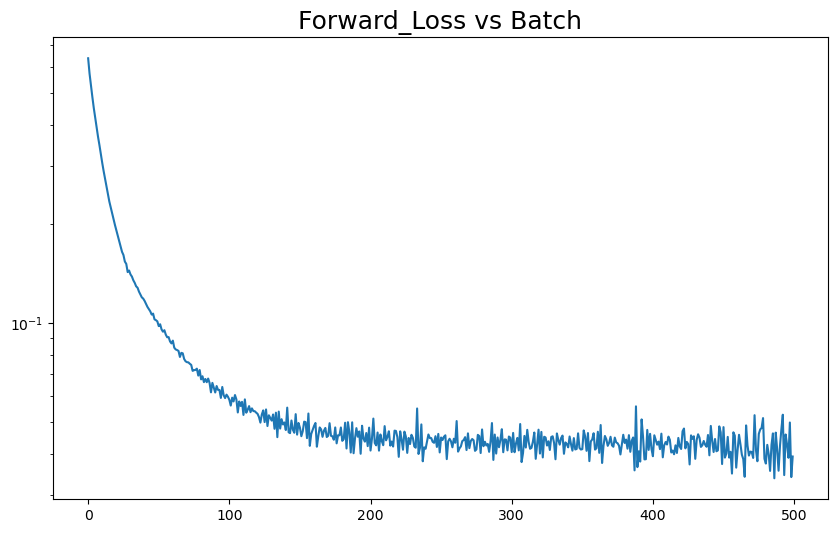

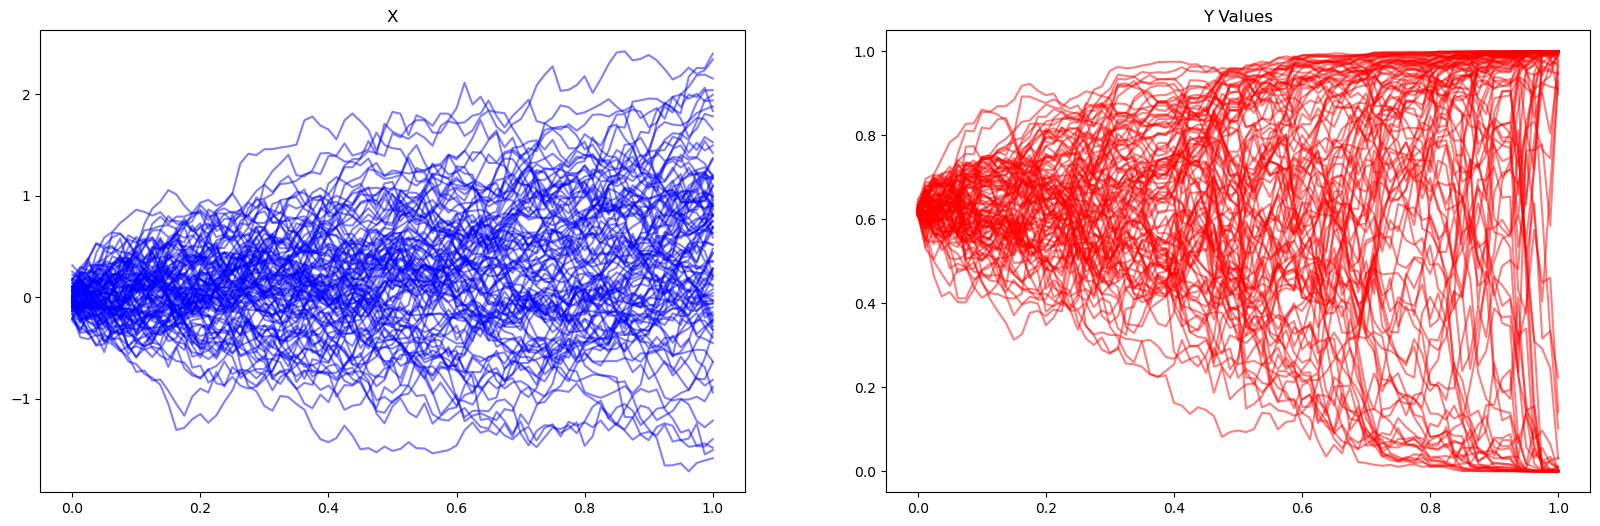

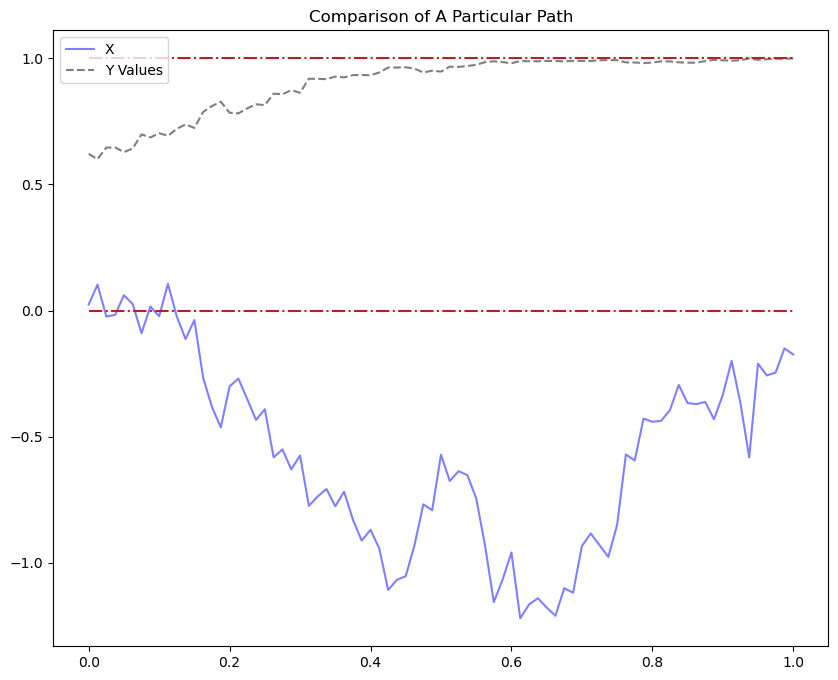

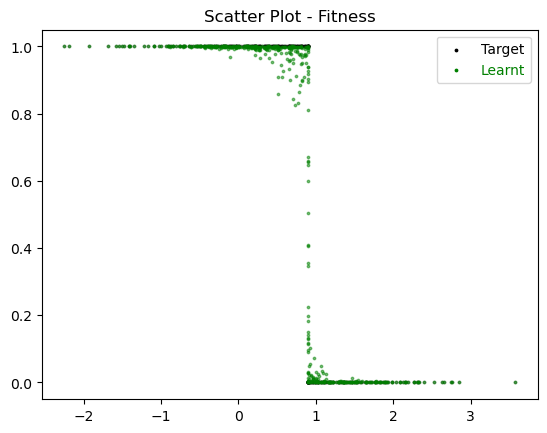

In [10]:
## Train 
torch.autograd.set_detect_anomaly(True)

dB = SampleBMIncr(1, Npaths=NumTrain, Nsteps=NT+1)
init_x =  Sample_Init(N=NumTrain)

#Forward Loss
forward_losses = []
#How many batches?
MaxBatch= 500

#How many optimization steps per batch
OptimSteps= 20

#Train on a single batch?
single_batch = True

#Set up main models for y0 and z (z will be list of models)
layer_dim = 10
y0_model_main = Network(lr=learning_rate, input_dims=1, fc1_dims=layer_dim, fc2_dims=layer_dim,
                     n_outputs=1)
z_models_main = [Network(lr=learning_rate, input_dims=1, fc1_dims=layer_dim, fc2_dims=layer_dim,
                     n_outputs=1) for i in range(NT)]



#Define optimization parameters
# params = list(y0_model_main.parameters())
params=[]
for i in range(NT):
    params += list(z_models_main[i].parameters())
    
#Set up optimizer and scheduler
optimizer = optim.Adamax(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.95)


for k in range(0,MaxBatch):

    print("Batch Number: ", k+1)
    sloss=0
    #optimize main network wrt the foward loss
    for l in range(0,OptimSteps):
        optimizer.zero_grad()

        loss = get_foward_loss(dB, init_x,NT=NT, y0_model=y0_model_main, z_models=z_models_main)
        # print(loss)
        
        loss.backward()
        # print(params)
        torch.nn.utils.clip_grad_norm_(parameters=params,max_norm=1.0)
        optimizer.step()
        scheduler.step()
        nloss = loss.detach().numpy()
        sloss += nloss
        # print('OptimStep: '+ str(l+1))
        # print('forward_loss: ' + str(nloss))
    avgloss = sloss/OptimSteps
    print("Average Error Est: ", avgloss)
    forward_losses.append(avgloss)

    #Generate a new batch if using multiple batches
    if(not single_batch):
        dB = SampleBMIncr(1, Npaths=NumTrain, Nsteps=NT+1)
        init_x =  Sample_Init(N=NumTrain)

plot=plot_results(loss=forward_losses)
plot.FwdLoss()
plot.results()
plot.Fitness()
